# Characterising trip distance of global regions

Fit the trip distance distribution using Weibull.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import math
import yaml
from scipy import stats
from scipy.stats import kurtosis
from scipy import optimize

import matplotlib.pyplot as plt

region_list = ['sweden', 'netherlands', 'saopaulo', 'australia', 'austria', 'barcelona',
               'capetown', 'cebu', 'egypt', 'guadalajara', 'jakarta',
               'johannesburg', 'kualalumpur', 'lagos', 'madrid', 'manila', 'moscow', 'nairobi',
               'rio', 'saudiarabia', 'stpertersburg', 'surabaya'] #, 'mexicocity'

with open('../../lib/regions.yaml', encoding='utf8') as f:
    region_manager = yaml.load(f, Loader=yaml.FullLoader)

runid = 6

## 1 Fit to trip distance distribution

In [3]:
region = 'saopaulo'
df = pd.read_csv(f'../../dbs/{region}/visits/visits_{runid}_trips_dom.csv')
df = df.loc[df.distance >= 0.1, :]

### 1.0 Get probability density function (estimated)

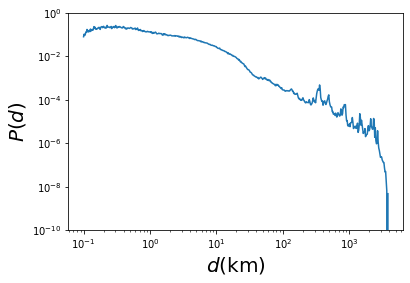

In [4]:
_, bins = np.histogram(np.log10(df.distance), bins='fd')
values, base = np.histogram(df.distance, bins=10**bins, density=1)
plt.plot(10**bins[0:-1], values, alpha = 1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

In [123]:
x = 10**bins[0:-1]
y = values
df_mod = pd.DataFrame()
df_mod.loc[:, 'd'] = x
df_mod.loc[:, 'p_d'] = y
df_mod.head()

,d,p_d
0,0.100008,0.077289
1,0.102018,0.101370
2,0.104068,0.088502
3,0.106159,0.100985
4,0.108293,0.126507


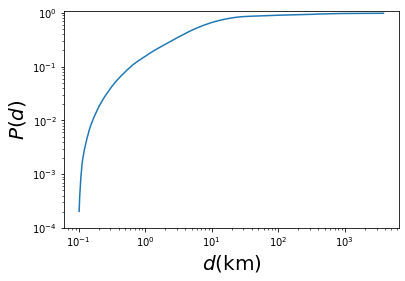

In [124]:
P_d = np.cumsum(np.diff(x)*y[1:])
plt.plot(x[1:], P_d, alpha = 1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4, 1.1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 2. Weibull distribution

In [89]:
def weibull(d, k, ld):
    return k/ld*(k/ld)**(k-1)*np.exp(-(d/ld)**k)
popt, pcov = optimize.curve_fit(weibull, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: k=%5.3f, ld=%5.3f'%tuple(popt))

[1.082122   5.24211137]
[[ 0.00243788 -0.00518729]
 [-0.00518729  0.01394915]]
fit: k=1.082, ld=5.242


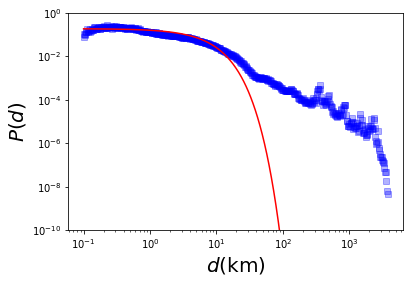

In [90]:
k, ld = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, weibull(x, k, ld), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

### 2.1 Weibull distribution - MLE

In [125]:
# define likelihood function
def weibullMLE(params):
    k, ld, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = k/ld*(k/ld)**(k-1)*np.exp(-(x/ld)**k) # predictions
    L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
    return L
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = optimize.minimize(weibullMLE, guess, method = 'Nelder-Mead',
                                  options={'disp': True})
results

Optimization terminated successfully.
         Current function value: -1298.688063
         Iterations: 148
         Function evaluations: 262


 final_simplex: (array([[ 1.08217064,  5.24199007, -0.0209698 ],
       [ 1.08214646,  5.24207363, -0.02096929],
       [ 1.08216944,  5.24196147, -0.0209695 ],
       [ 1.08218769,  5.24200365, -0.02096899]]), array([-1298.68806298, -1298.68806286, -1298.68806265, -1298.6880621 ]))
           fun: -1298.6880629830187
       message: 'Optimization terminated successfully.'
          nfev: 262
           nit: 148
        status: 0
       success: True
             x: array([ 1.08217064,  5.24199007, -0.0209698 ])

fit: k=1.082, ld=5.242


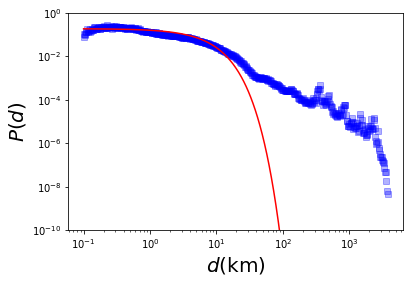

In [126]:
k, ld, _ = results['x']
print('fit: k=%5.3f, ld=%5.3f'%(k, ld))
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, weibull(x, k, ld), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()


## 3. Gamma distribution

In [38]:
def gamma(d, alpha, beta):
    return beta**alpha*d**(alpha-1)*np.exp(-beta*d)/math.gamma(alpha)
popt, pcov = optimize.curve_fit(gamma, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: alpha=%5.3f, beta=%5.3f'%tuple(popt))

[0.90051383 0.14291788]
[[1.63467013e-04 6.27661923e-05]
 [6.27661923e-05 2.68603237e-05]]
fit: alpha=0.901, beta=0.143


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


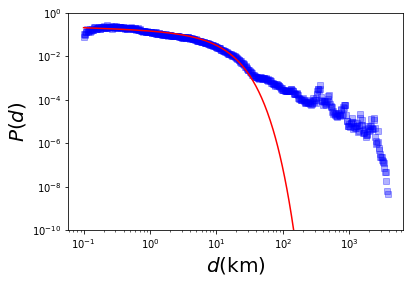

In [39]:
alpha, beta = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, gamma(x, alpha, beta), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

### 3.1 Gamma distribution - MLE

In [128]:
# define likelihood function
def gammaMLE(params):
    alpha, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = beta**alpha*x**(alpha-1)*np.exp(-beta*x)/math.gamma(alpha)
    L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
    # return negative LL
    return L
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = optimize.minimize(gammaMLE, guess, method = 'Nelder-Mead',
                                  options={'disp': True})
results

Optimization terminated successfully.
         Current function value: -503.574771
         Iterations: 114
         Function evaluations: 218


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


 final_simplex: (array([[ 3.31821721e+01,  3.35546879e-03, -9.37343479e-02],
       [ 3.31820886e+01,  3.37400605e-03, -9.37344121e-02],
       [ 3.31821497e+01,  3.36032034e-03, -9.37343259e-02],
       [ 3.31822529e+01,  3.33780817e-03, -9.37344338e-02]]), array([-503.57477054, -503.57477054, -503.57477054, -503.57477054]))
           fun: -503.5747705436883
       message: 'Optimization terminated successfully.'
          nfev: 218
           nit: 114
        status: 0
       success: True
             x: array([ 3.31821721e+01,  3.35546879e-03, -9.37343479e-02])

fit: alpha=33.182, beta=0.003


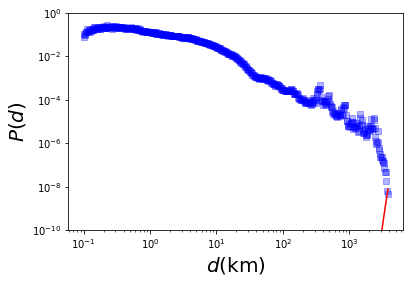

In [129]:
alpha, beta, _ = results['x']
print('fit: alpha=%5.3f, beta=%5.3f'%(alpha, beta))
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, gamma(x, alpha, beta), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 4. Lognormal

In [45]:
def lognormal(d, miu, sigma):
    return 1/(d*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(d) - miu)**2/(2*sigma**2))
popt, pcov = optimize.curve_fit(lognormal, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: miu=%5.3f, sigma=%5.3f'%tuple(popt))

[1.64615235 1.70946811]
[[0.00023769 0.00016331]
 [0.00016331 0.00013878]]
fit: miu=1.646, sigma=1.709


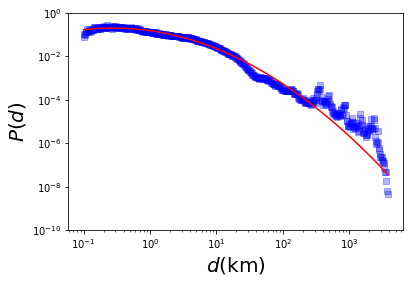

In [46]:
miu, sigma = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, lognormal(x, miu, sigma), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

### 4.1 Lognormal distribution - MLE

In [130]:
# define likelihood function
def lognormalMLE(params):
    miu, sigma, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = 1/(x*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(x) - miu)**2/(2*sigma**2))
    L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
    # return negative LL
    return L
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = optimize.minimize(lognormalMLE, guess, method = 'Nelder-Mead',
                                  options={'disp': True})
results

Optimization terminated successfully.
         Current function value: -1543.710316
         Iterations: 122
         Function evaluations: 223


 final_simplex: (array([[1.64611948, 1.70944162, 0.01321874],
       [1.64619476, 1.7094881 , 0.01321881],
       [1.6461401 , 1.70945568, 0.01321755],
       [1.64616845, 1.70950227, 0.01321953]]), array([-1543.71031607, -1543.71031384, -1543.71031345, -1543.71030674]))
           fun: -1543.710316065698
       message: 'Optimization terminated successfully.'
          nfev: 223
           nit: 122
        status: 0
       success: True
             x: array([1.64611948, 1.70944162, 0.01321874])

fit: miu=1.646, sigma=1.709


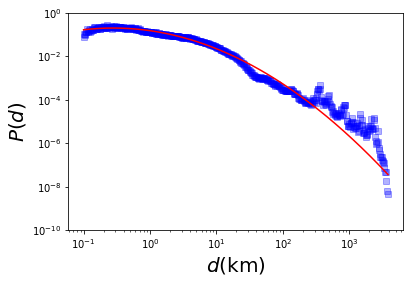

In [131]:
miu, sigma, _ = results['x']
print('fit: miu=%5.3f, sigma=%5.3f'%(miu, sigma))
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, lognormal(x, miu, sigma), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 5. Truncated power law

In [14]:
def truncated_power_law(x, d0, beta, K):
    return (x + d0) ** (-beta) * np.exp(-x / K)
popt, pcov = optimize.curve_fit(truncated_power_law, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: d0=%5.3f, beta=%5.3f, '
      'K=%5.3f'%tuple(popt))

[1.86373461e+00 1.65768266e+00 1.00769971e+06]
[[ 2.63967286e-02 -2.91454254e-02 -6.10643879e+09]
 [-2.91454254e-02  3.38562184e-02  7.42277258e+09]
 [-6.10643879e+09  7.42277258e+09  1.95449644e+21]]
fit: d0=1.864, beta=1.658, K=1007699.710


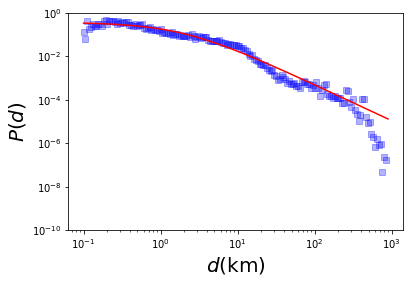

In [15]:
d0, beta, K = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, truncated_power_law(x, d0, beta, K), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 6. Power law

In [16]:
def power(d, alpha, k):
    return alpha*d**(-k)
popt, pcov = optimize.curve_fit(power, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: alpha=%5.3f, k=%5.3f'%tuple(popt))

[0.14451789 0.42430129]
[[ 4.41658283e-05 -1.31362060e-04]
 [-1.31362060e-04  7.87080404e-04]]
fit: alpha=0.145, k=0.424


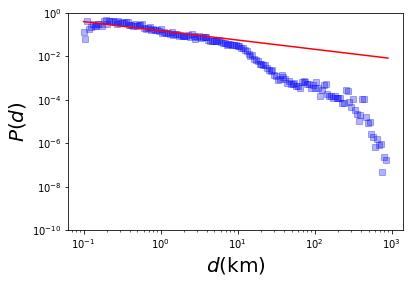

In [17]:
alpha, k = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, power(x, alpha, k), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 7. Exponential

In [18]:
def exponential(d, ld):
    return ld*np.exp(-ld*d)
popt, pcov = optimize.curve_fit(exponential, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)

print('fit: ld=%5.3f'%tuple(popt))

[0.29311696]
[[9.14932984e-05]]
fit: ld=0.293


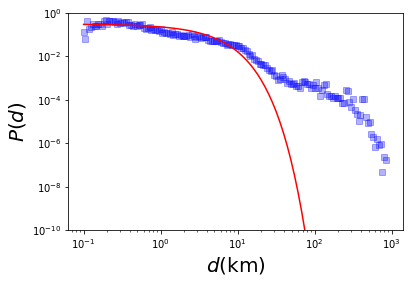

In [19]:
ld = popt[0]
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, exponential(x, ld), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 8. Power law altered

In [20]:
def powerlaw_al(x, d0, beta):
    return (x + d0)**(-beta)
popt, pcov = optimize.curve_fit(powerlaw_al, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)
print('fit: d0=%5.3f, beta=%5.3f'%tuple(popt))

[1.86373443 1.6576834 ]
[[ 0.00727345 -0.0059182 ]
 [-0.0059182   0.00563189]]
fit: d0=1.864, beta=1.658


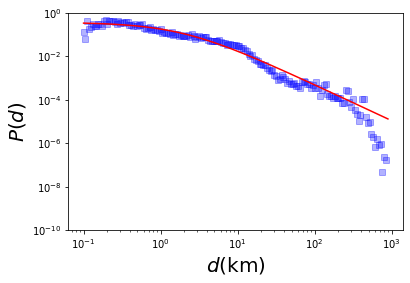

In [21]:
d0, beta = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, powerlaw_al(x, d0, beta), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()


## 9. Stretched power law

In [88]:
def powerlaw_str(x, d0, beta, ld):
    return (x + d0)**(beta-1)*np.exp(-ld*x**beta)
popt, pcov = optimize.curve_fit(powerlaw_str, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)
print('fit: d0=%5.3f, beta=%5.3f, ld=%5.3f'%tuple(popt))

[ 0.06253019 -0.38201148  1.87585584]
[[ 0.00239106  0.00156227 -0.00313647]
 [ 0.00156227  0.00103135 -0.00202877]
 [-0.00313647 -0.00202877  0.00416453]]
fit: d0=0.063, beta=-0.382, ld=1.876


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


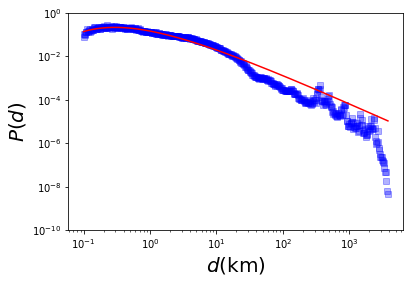

In [89]:
d0, beta, ld = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, powerlaw_str(x, d0, beta, ld), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 10. Two-part exponential + power law 2

In [80]:
def two_part(d, d0, K, miu, sigma):
    c_d0 = (d0 + d0)**(-K)
    c = 1/(d0*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(d0) - miu)**2/(2*sigma**2))
    return np.piecewise(d, [d <= d0, d > d0],
                        [lambda x: (x + d0)**(-K), #
                         lambda x: c_d0/c*1/(x*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(x) - miu)**2/(2*sigma**2))])  #(x + d0)**(-beta) (**)
popt, pcov = optimize.curve_fit(two_part, x, y) # , p0=[1.8, 0.15, 5]
print(popt)
print(pcov)
print('fit: d0=%5.3f, K=%5.3f, miu=%5.3f, sigma=%5.3f'%tuple(popt))
print(stats.ks_2samp(y, two_part(x, d0, K, miu, sigma)))

[2.90848007 1.45901851 1.80681899 1.07938998]
[[ 0.00638265 -0.00218077 -0.00106541  0.00259068]
 [-0.00218077  0.00078992  0.00042241 -0.00102714]
 [-0.00106541  0.00042241  0.01080279  0.01153533]
 [ 0.00259068 -0.00102714  0.01153533  0.03155373]]
fit: d0=2.908, K=1.459, miu=1.807, sigma=1.079
KstestResult(statistic=0.1544256120527307, pvalue=6.092158264858317e-06)


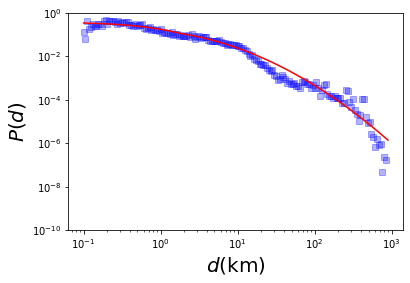

In [72]:
d0, K, miu, sigma = tuple(popt)
plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, two_part(x, d0, K, miu, sigma), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1)
plt.xlabel('$d$(km)', fontsize = 20)
plt.ylabel('$P(d)$', fontsize = 20)
plt.show()

## 2. Fit existing distributions from raw data

In [74]:
import scipy.stats as st
dist = st.lognorm
args = dist.fit(df.distance)
st.kstest(df.distance, dist.cdf, args)

KstestResult(statistic=0.06977662685853037, pvalue=0.0)

## 3. Calculate PDF for all the regions and save the fitted results

In [184]:
def r2_cal(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2


def pdf_extraction(region, df):
    df_out = pd.DataFrame()
    _, bins = np.histogram(np.log10(df.distance), bins='fd')
    values, base = np.histogram(df.distance, bins=10**bins, density=1)
    x = 10**bins[0:-1]
    y = values
    df_out.loc[:, 'd'] = x
    df_out.loc[:, 'y'] = y
    df_out = df_out.loc[df_out.y > 1e-10, :]
    df_out.loc[:, 'region'] = region
    return df_out

def cdf_extraction(region, df_pdf):
    x = df_pdf.loc[:, 'd'].values
    y = df_pdf.loc[:, 'y'].values
    P_d = np.cumsum(np.diff(x)*y[1:])
    df_out = pd.DataFrame()
    df_out.loc[:, 'd'] = x[1:]
    df_out.loc[:, 'y'] = P_d
    df_out.loc[:, 'region'] = region
    return df_out

def pdf_fit(df, df_out, region, func_name=None):
    x = df_out.loc[:, 'd'].values
    y = df_out.loc[:, 'y'].values
    P_d = np.cumsum(np.diff(x)*y[1:])
    if func_name == 'powerlaw_al':
        def powerlaw_al(d, d0, beta):
            return (d + d0)**(-beta)

        def powerlaw_alMLE(params):
            d0, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
            yhat = (x + d0)**(-beta)
            L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
            # return negative LL
            return L
        guess = np.array([5,5,2])
        results = optimize.minimize(powerlaw_alMLE, guess, method = 'Nelder-Mead', options={'disp': False})
        para1, para2, _ = results['x']
        aic = -2*results['fun'] + 2*3
        yhat = powerlaw_al(x, para1, para2)
        para3 = np.nan

    if func_name == 'lognormal':
        def lognormal(d, miu, sigma):
            return 1/(d*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(d) - miu)**2/(2*sigma**2))

        # define likelihood function
        def lognormalMLE(params):
            miu, sigma, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
            yhat = 1/(x*sigma*(2*np.pi)**0.5)*np.exp(-(np.log(x) - miu)**2/(2*sigma**2))
            L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
            # return negative LL
            return L
        guess = np.array([5,5,2])
        results = optimize.minimize(lognormalMLE, guess, method = 'Nelder-Mead', options={'disp': False})
        para1, para2, _ = results['x']
        aic = -2*results['fun'] + 2*3
        yhat = lognormal(x, para1, para2)
        para3 = np.nan

    if func_name == 'truncated_power_law':
        def truncated_power_law(d, d0, beta, K):
            return (d + d0) ** (-beta) * np.exp(-d / K)

        def truncated_power_lawMLE(params):
            d0, beta, K, sd = params[0], params[1], params[2], params[3] # inputs are guesses at our parameters
            yhat = (x + d0) ** (-beta) * np.exp(-x / K)
            L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sd ** 2) + 1 / (2 * sd ** 2) * sum((y - yhat) ** 2))
            # return negative LL
            return L
        guess = np.array([5,5,5,2])
        results = optimize.minimize(truncated_power_lawMLE, guess, method = 'Nelder-Mead', options={'disp': False})
        para1, para2, para3, _ = results['x']
        aic = -2*results['fun'] + 2*4
        yhat = truncated_power_law(x, para1, para2, para3)

    paras_dict = {'para1': para1, 'para2': para2, 'para3': para3, 'd': x, 'd_P': x[1:],
                  'p_dhat': yhat, 'P_dhat': np.cumsum(np.diff(x)*yhat[1:])}
    success = results['success']
    P_dhat = np.cumsum(np.diff(x)*yhat[1:])
    r2 = r2_cal(y, yhat)

    #_, ks_p = stats.ks_2samp(P_d, P_dhat)
    _, ks_p = stats.ks_2samp(y, yhat)
    ks = kurtosis(df.distance, fisher=True)
    median = np.median(df.distance)
    return (region, func_name, r2, ks_p, aic, success, median, ks), paras_dict

def pdf_fit_r(df_out, region, func=None, func_name=None):
    if func_name in ['powerlaw_al', 'lognormal']:
        popt, _ = optimize.curve_fit(func, df_out.loc[:, 'd'].values,
                                     df_out.loc[:, 'p_d'].values,
                                     maxfev = 1000)
        para1, para2 = tuple(popt)
        yhat = func(df_out.loc[:, 'd'].values, para1, para2)
        negLL = -np.sum( stats.norm.logpdf(df_out.loc[:, 'p_d'].values,
                                           loc=yhat, scale=np.std(df_out.loc[:, 'p_d'].values)) )
#        P_d = np.cumsum(np.diff(df_out.loc[:, 'd'].values)*df_out.loc[:, 'p_d'].values[1:])
#        P_dhat = np.cumsum(np.diff(df_out.loc[:, 'd'].values)*yhat[1:])
        r2 = r2_cal(df_out.loc[:, 'p_d'].values, yhat)
        _, ks_p = stats.ks_2samp(df_out.loc[:, 'p_d'].values, yhat)
    else:
        popt, _ = optimize.curve_fit(func, df_out.loc[:, 'd'].values,
                                     df_out.loc[:, 'p_d'].values,
                                     maxfev = 1000)
        para1, para2, para3 = tuple(popt)
        yhat = func(df_out.loc[:, 'd'].values, para1, para2, para3)
        negLL = -np.sum( stats.norm.logpdf(df_out.loc[:, 'p_d'].values,
                                           loc=yhat, scale=np.std(df_out.loc[:, 'p_d'].values)) )
        P_d = np.cumsum(np.diff(df_out.loc[:, 'd'].values)*df_out.loc[:, 'p_d'].values[1:])
        P_dhat = np.cumsum(np.diff(df_out.loc[:, 'd'].values)*yhat[1:])
        r2 = r2_cal(df_out.loc[:, 'p_d'].values, yhat)
        _, ks_p = stats.ks_2samp(df_out.loc[:, 'p_d'].values, yhat)
    #ks = kurtosis(df.distance, fisher=True)
    #median = np.median(df.distance)
    return region, func_name, r2, ks_p, negLL

### 2.1 Extract PDF and CDF for all the regions (histograms-based)

In [182]:
list_df_out = []
list_df_out_cdf = []
for region in tqdm(region_list, desc='PDF and fitting'):
    df = pd.read_csv(f'../../dbs/{region}/visits/visits_{runid}_trips_dom.csv')
    df = df.loc[df.distance >= 0.1, :]
    df_out = pdf_extraction(region, df)
    df_out_cdf = cdf_extraction(region, df_out)
    list_df_out.append(df_out)
    list_df_out_cdf.append(df_out_cdf)
df_out = pd.concat(list_df_out)
df_out.loc[:, 'type'] = 'pdf'
df_out_cdf = pd.concat(list_df_out_cdf)
df_out_cdf.loc[:, 'type'] = 'cdf'
df_out = pd.concat([df_out, df_out_cdf])
df_out.to_csv(f'../../results/multi-region_trips_rid_{runid}_pcdf.csv', index=False)

PDF and fitting: 100%|██████████| 22/22 [01:06<00:00,  3.04s/it]


### 2.2 Find the best model

In [185]:
list_paras = []
paras_dict = {}
df = pd.read_csv(f'../../results/multi-region_trips_rid_{runid}_pcdf.csv')
df = df.loc[df.type == 'pdf', :]
for region in tqdm(region_list, desc='PDF and fitting'):
    df_out = df.loc[df.region==region, :]
    df_raw = pd.read_csv(f'../../dbs/{region}/visits/visits_{runid}_trips_dom.csv')
    df_raw = df_raw.loc[df_raw.distance >= 0.1, :]
    paras_dict[region] = {}
    for func_name in ['powerlaw_al', 'lognormal', 'truncated_power_law']:
        #ot = pdf_fit_r(df_out, region, func=func, func_name=func_name)
        ot, paras_rec_dict = pdf_fit(df_raw, df_out, region, func_name=func_name)
        paras_dict[region][func_name] = paras_rec_dict
        list_paras.append(ot)
df_paras = pd.DataFrame(list_paras, columns=['region', 'func_name', 'r2', 'ks_p', 'aic', 'success', 'median', 'ks'])
df_paras

PDF and fitting:   5%|▍         | 1/22 [00:02<01:02,  2.99s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in exp
PDF and fitting:  95%|█████████▌| 21/22 [01:06<00:02,  2.66s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in square
PDF and fitting: 100%|██████████| 22/22 [01:08<00:00,  3.12s/it]


,region,func_name,r2,ks_p,aic,success,median,ks
0,sweden,powerlaw_al,-0.650344,2.128600e-109,468.683063,True,5.643772,24.513276
1,sweden,lognormal,0.972541,1.456236e-01,1525.466447,True,5.643772,24.513276
2,sweden,truncated_power_law,0.931649,4.704071e-08,1292.176213,True,5.643772,24.513276
3,netherlands,powerlaw_al,0.923065,2.146167e-01,1174.026537,True,7.289438,6.322702
4,netherlands,lognormal,0.960375,9.226794e-02,1331.277126,True,7.289438,6.322702
...,...,...,...,...,...,...,...,...
61,stpertersburg,lognormal,0.968312,5.215533e-03,1798.197700,True,5.657114,52.289315
62,stpertersburg,truncated_power_law,0.934958,5.859995e-24,1586.615681,True,5.657114,52.289315
63,surabaya,powerlaw_al,0.901017,2.666228e-04,1705.426513,True,4.529086,84.407852
64,surabaya,lognormal,0.933715,1.849031e-01,1857.000057,True,4.529086,84.407852


In [186]:
def select(data):
    dat = data.loc[data.ks_p > 0.05, :]
    if len(dat) > 0:
        return dat.loc[dat["r2"].idxmax(), ['func_name', 'r2', 'ks_p', 'median', 'ks']] #ks_p
    else:
        return data.loc[data["r2"].idxmax(), ['func_name', 'r2', 'ks_p', 'median', 'ks']] #ks_p
df_paras_optimal = df_paras.groupby("region").apply(select).reset_index()
df_paras_optimal

,region,func_name,r2,ks_p,median,ks
0,australia,lognormal,0.970512,0.089175,5.857203,47.539585
1,austria,lognormal,0.923983,0.717241,4.237668,27.915971
2,barcelona,lognormal,0.952476,0.076666,3.406121,89.540808
3,capetown,lognormal,0.909747,0.475920,5.501415,37.173614
4,cebu,lognormal,0.953076,0.265284,3.541143,27.993374
5,egypt,lognormal,0.897992,0.371112,5.178500,23.819367
6,guadalajara,lognormal,0.902858,0.275430,5.166505,44.405040
7,jakarta,lognormal,0.945387,0.005844,5.105821,88.726032
8,johannesburg,lognormal,0.911195,0.488581,7.287211,37.673390
9,kualalumpur,lognormal,0.952483,0.017769,6.505288,166.130684


In [187]:
df_paras_optimal.loc[df_paras_optimal.ks_p <= 0.05, :]

,region,func_name,r2,ks_p,median,ks
7,jakarta,lognormal,0.945387,0.005844,5.105821,88.726032
9,kualalumpur,lognormal,0.952483,0.017769,6.505288,166.130684
11,madrid,lognormal,0.974219,0.016371,4.423456,20.470743
16,rio,lognormal,0.957468,0.036937,6.937114,63.760574
17,saopaulo,lognormal,0.968504,0.008123,5.445212,68.286222
19,stpertersburg,lognormal,0.968312,0.005216,5.657114,52.289315


### 2.3 Save the modelled data with the optimal parameters and estimated pdf and cdf

In [188]:
for var in ['para1', 'para2', 'para3']:
    df_paras_optimal.loc[:, var] = df_paras_optimal.apply(lambda row: paras_dict[row['region']][row['func_name']][var],
                                                          axis=1)

In [189]:
df_paras_optimal.to_csv(f'../../results/multi-region_trips_rid_{runid}_paras.csv', index=False)

In [191]:
# Save pdf and cdf
#  paras_dict = {'para1': para1, 'para2': para2, 'para3': para3,
#  'd': x, 'd_P': x[1:], 'p_dhat': yhat, 'P_dhat': np.cumsum(np.diff(x)*yhat[1:])}
list_df_out_m = []
def prep_estimated_pdf_cdf(row):
    tp1 = pd.DataFrame()
    tp1.loc[:, 'd'] = paras_dict[row['region']][row['func_name']]['d']
    tp1.loc[:, 'y'] = paras_dict[row['region']][row['func_name']]['p_dhat']
    tp1.loc[:, 'type'] = 'pdf'
    tp2 = pd.DataFrame()
    tp2.loc[:, 'd'] = paras_dict[row['region']][row['func_name']]['d_P']
    tp2.loc[:, 'y'] = paras_dict[row['region']][row['func_name']]['P_dhat']
    tp2.loc[:, 'type'] = 'cdf'
    tp = pd.concat([tp1, tp2])
    tp.loc[:, 'region'] = row['region']
    tp.loc[:, 'func_name'] = row['func_name']
    return tp

for _, row in df_paras_optimal.iterrows():
    list_df_out_m.append(prep_estimated_pdf_cdf(row))
df_out_m = pd.concat(list_df_out_m)

In [192]:
df_out_m.to_csv(f'../../results/multi-region_trips_rid_{runid}_pcdf_model.csv', index=False)

## 3. Parameters and region characteristics

In [207]:
df_paras = pd.read_csv(f'../../results/multi-region_trips_rid_{runid}_paras.csv')
df_stats = pd.read_csv(f'../../results/multi-region_stats_rid_{runid}.csv')
df_combi = pd.merge(df_paras, df_stats, on='region')
df_combi.columns

Index(['region', 'func_name', 'r2', 'ks_p', 'median', 'ks', 'para1', 'para2',
       'para3', 'num_users', 'num_geotweets', 'pkt', 'pkt_inland', 'num_trips',
       'num_trips_inland', 'days', 'pkt_yr', 'num_trips_yr', 'pkt_inland_yr',
       'num_trips_inland_yr', 'gdp_capita', 'region_name', 'country',
       'pop_country', 'pkt_yr_capita', 'pkt_inland_yr_capita', 'city'],
      dtype='object')

In [208]:
df_combi = df_combi.loc[:, ['region', 'ks', 'median', 'r2', 'ks_p', 'func_name', 'num_users',
                            'num_geotweets', 'pkt_inland_yr_capita', 'gdp_capita', 'region_name', 'city',
                            'para1', 'para2']]
df_combi.loc[:, 'area'] = df_combi.loc[:, 'region'].apply(lambda x: region_manager[x]['country_area']) # km^2
df_combi.loc[:, 'pop'] = df_combi.loc[:, 'region'].apply(lambda x: region_manager[x]['pop']) # km^2
df_combi

,region,ks,median,r2,ks_p,func_name,num_users,num_geotweets,pkt_inland_yr_capita,gdp_capita,region_name,city,para1,para2,area,pop
0,australia,47.539585,5.857203,0.970512,0.089175,lognormal,3310,847668,16.369851,57.40,Australia,0,1.649611,1.670024,7692000,24.99
1,austria,27.915971,4.237668,0.923983,0.717241,lognormal,729,168364,5.548505,51.50,Austria,0,1.408290,1.627560,83879,8.56
2,barcelona,89.540808,3.406121,0.952476,0.076666,lognormal,1891,482357,10.033088,33.10,"Barcelona, Spain",1,1.285092,1.509412,505990,5.56
3,capetown,37.173614,5.501415,0.909747,0.475920,lognormal,1092,193993,14.822132,6.20,"Cape Town, South Africa",1,1.494010,1.664408,1220000,0.43
4,cebu,27.993374,3.541143,0.953076,0.265284,lognormal,1486,400094,6.533161,3.10,"Cebu, Philippines",1,1.329132,1.533511,300000,0.92
5,egypt,23.819367,5.178500,0.897992,0.371112,lognormal,1464,234322,6.792347,2.55,Egypt,0,1.145043,1.695983,1010000,98.42
6,guadalajara,44.405040,5.166505,0.902858,0.275430,lognormal,684,212681,9.681318,17.88,"Guadalajara, Mexico",1,1.781453,1.705999,1973000,1.50
7,jakarta,88.726032,5.105821,0.945387,0.005844,lognormal,13088,4650699,8.369519,19.03,"Jakarta, Indonesia",1,1.446031,1.690288,1905000,9.61
8,johannesburg,37.673390,7.287211,0.911195,0.488581,lognormal,1268,214187,12.603423,16.37,"Johannesburg, South Africa",1,1.574816,1.792949,1220000,0.96
9,kualalumpur,166.130684,6.505288,0.952483,0.017769,lognormal,4663,1543306,6.455785,11.14,"Kuala Lumpur, Malaysia",1,2.089194,1.932672,329847,1.81


In [210]:
df_combi.to_csv(f'../../results/multi-region_rid_{runid}.csv', index=False)

In [212]:
df_combi.loc[df_combi.ks_p <= 0.05, 'region_name'].to_list()

['Jakarta, Indonesia',
 'Kuala Lumpur, Malaysia',
 'Madrid, Spain',
 'Rio de Janeiro, Brazil',
 'São Paulo, Brazil',
 'Saint Petersburg, Russia']

In [213]:
df_combi.loc[df_combi.region != 'manila', ['para1','para2']].mean(),\
df_combi.loc[df_combi.region != 'manila', ['para1','para2']].std()


(para1    1.536875
 para2    1.681270
 dtype: float64, para1    0.268696
 para2    0.104345
 dtype: float64)

## 4. Aggregate all regions' raw distance data into one file

In [216]:
list_df_distance_raw = []
for region in tqdm(region_list, desc='PDF and fitting'):
    df = pd.read_csv(f'../../dbs/{region}/visits/visits_{runid}_trips_dom.csv')
    df = df.loc[df.distance >= 0.1, ['distance']]
    df.loc[:, 'region_name'] = region_manager[region]['name']
    df.loc[:, 'region'] = region
    list_df_distance_raw.append(df)
df_distance_raw = pd.concat(list_df_distance_raw)
df_distance_raw.to_csv(f'../../dbs/visits_{runid}_trips_dom.csv', index=False)

PDF and fitting: 100%|██████████| 22/22 [01:03<00:00,  2.89s/it]
